# Load Packages

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import datasets
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import jit, vmap
from jax.scipy.stats import norm


from src.load_data import load_traintest_sparseclass
from src import conformal_Bayes_functions as cb
from src import Bayes_MCMC_functions as bmcmc
from src.conformal_Bayes_functions import compute_rank_IS, compute_cb_region_IS, diagnose_IS_weights
from src.Bayes_MCMC_functions import compute_bayes_band_MCMC



/opt/anaconda3/envs/BCP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define Bayesian Spares Model

In [2]:
def sparse_linear_model(X, y=None, c=1.0):  # c is the prior
    """
    Bayesian sparse linear model matching the paper:
      y ~ Normal(X * theta + theta_0, tau^2)
      theta_j ~ Laplace(loc=0, scale=b)
      b ~ Gamma(1, 1)
      tau ~ HalfNormal(0, c)  # c controls how informative the prior is
    """
    n_features = X.shape[1]
    
    # Prior on tau (noise scale) - now parameterized with c
    tau = numpyro.sample("tau", dist.HalfNormal(c))
    
    # Prior on b (scale parameter for Laplace)
    b = numpyro.sample("b", dist.Gamma(1.0, 1.0))
    
    # Laplace prior on each coefficient
    with numpyro.plate("coeff_plate", n_features):
        theta = numpyro.sample("theta", dist.Laplace(0.0, b))
    
    # Intercept with flat prior
    theta_0 = numpyro.sample("theta_0", dist.Normal(0., 10.))
    
    # Mean of the likelihood
    mu = jnp.dot(X, theta) + theta_0
    
    # Likelihood of y
    numpyro.sample("obs", dist.Normal(mu, tau), obs=y)
    
def run_mcmc_sparse_model(X, y, c=1.0, num_warmup=1000, num_samples=8000, num_chains=1):
    """
    Runs NUTS MCMC for the sparse linear regression model with specified prior parameter c.
    """
    # Create a NUTS sampler for our model with the c parameter
    kernel = NUTS(lambda X, y: sparse_linear_model(X, y, c))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    
    # Run MCMC
    mcmc.run(jax.random.PRNGKey(0), X, y)
    # mcmc.print_summary()
    
    return mcmc.get_samples()


# Load Dataset

In [3]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Standardize the data as mentioned in the paper
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Non-conformity Score
### `build_logp_samp_n`

* **Equation&nbsp;(4)** gives the per-observation posterior-predictive density  

  $$
    p\!\bigl(Y_i \mid X_i, Z_{1:n}\bigr)\;=\;
    \int
        f_{\theta}\!\bigl(Y_i \mid X_i\bigr)\,
        \pi\!\bigl(\theta \mid Z_{1:n}\bigr)\,
    \mathrm d\theta .
  $$

  Because this integral is intractable for the sparse-linear model, the paper approximates it with Monte-Carlo draws  
  $\{\theta^{(t)}\}_{t=1}^{T}$ from the posterior, yielding  

  $$
    \widehat{p}\!\bigl(Y_i \mid X_i, Z_{1:n}\bigr)
      \;=\;
      \sum_{t=1}^{T} w^{(t)}
      f_{\theta^{(t)}}\!\bigl(Y_i \mid X_i\bigr).
  $$

* **Section 2.2** then uses these point-wise predictive densities as *conformity scores* in the conformal-Bayes (CB) / add-one-in importance-sampling (AOI-IS) procedure.

The helper `build_logp_samp_n` constructs the matrix  

$$
  \Bigl[
    \log f_{\theta^{(t)}}\!\bigl(Y_i \mid X_i\bigr)
  \Bigr]_{t=1,\dots,T;\; i=1,\dots,n},
$$

which is exactly the input required by the AOI formulas (Equations 5–6).

In [4]:
from jax.scipy.special import logsumexp
import jax.numpy as jnp
from jax import jit
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm

# ------------------------------------------------------------------
# 1.  Build    logp_samp_n   ——  training-point log-likelihoods
#               shape (B, n)
# ------------------------------------------------------------------
@jit
def build_logp_samp_n(X_train,             # (n, d)
                      y_train,             # (n,)
                      theta_samples,       # (B, d)
                      intercept_samples,   # (B,)
                      tau_samples):        # (B,)
    """
    log f_{θ(t)}(Y_i | X_i)  for every posterior draw t and every data point i.
    """
    means = jnp.matmul(theta_samples, X_train.T) + intercept_samples[:, None]  # (B, n)
    return norm.logpdf(y_train, means, tau_samples[:, None])                   # (B, n)

from src.nonconformity_score import build_logpdf_matrix, build_logp_samp_n_postpred    

# Add-One-In Sampling

### `build_logwjk`

* **AOI importance weights (Section 2.2, Eq. 6)**  
  For a new covariate vector $X_{n+1}$ and a grid of candidate responses
  $\{y_j\}_{j=1}^{G}$, the paper assigns each posterior draw
  $\theta^{(t)}$ the weight  

  $$
    w_j^{(t)}
      \;=\;
      f_{\theta^{(t)}}\!\bigl(y_j \mid X_{n+1}\bigr)
      \;=\;
      \mathcal N\!\bigl(
        y_j \mid \mu^{(t)}, (\tau^{(t)})^{2}
      \bigr),
  $$  

  where  

  $$
    \mu^{(t)} = \theta^{(t)\!\top} X_{n+1} + \theta_0^{(t)} .
  $$  

  These weights are later **normalised** and used to re-average the training-point
  likelihoods when computing conformal-Bayes scores.

* **What the helper returns**  
  `build_logwjk` constructs the matrix of **log-weights**

  $$
    \bigl[\log w_j^{(t)}\bigr]_{j=1,\ldots,G;\;t=1,\ldots,B}
    \;\in\;
    \mathbb R^{G\times B},
  $$

  where rows index grid values $y_j$ and columns index posterior draws $t$.


This log-weight matrix is the direct input required by the AOI routines
`compute_rank_IS`, `compute_cb_region_IS`, and `diagnose_IS_weights`
to implement Equations (5)–(6) of the paper.


In [5]:
# ------------------------------------------------------------------
# 2.  Build    logwjk        ——  AOI log-weights for each y on a grid
#               shape (n_grid, B)
# ------------------------------------------------------------------
@jit
def build_logwjk(y_grid,               # (n_grid,)
                 X_new,                # (d,)   – features of the target point
                 theta_samples,        # (B, d)
                 intercept_samples,    # (B,)
                 tau_samples):         # (B,)
    """
    log w_j^{(t)} = log f_{θ(t)}(y_grid[j] | X_new)
    """
    mu_new = jnp.dot(theta_samples, X_new) + intercept_samples               # (B,)
    return norm.logpdf(y_grid[:, None], mu_new[None, :], tau_samples[None, :])  # (n_grid, B)

### `conformal_region_IS`

This wrapper turns the three low-level building blocks from Section&nbsp;2.2 of the paper  
into a single call that yields the **conformal-Bayes (CB) prediction set** for one
test covariate vector $X_{n+1}$.

---

#### 1&nbsp;&nbsp;Compute training-point log-likelihoods  
```python
logp_samp_n = build_logp_samp_n( … )        #  shape (B, n)
```

*Creates the table*  
$$
  \ell_{t,i}
  \;=\;
  \log f_{\theta^{(t)}}\!\bigl(Y_i \mid X_i\bigr),
  \qquad
  t=1,\dots,B,\; i=1,\dots,n ,
$$  
which is the Monte-Carlo estimate of the posterior-predictive density
used as **non-conformity scores** (Eq.&nbsp;4 of the paper).

---

#### 2&nbsp;&nbsp;Compute AOI log-weights for every grid value  
```python
logwjk = build_logwjk( … )                  #  shape (G, B)
```

For each candidate response $y_j$ in the grid  
$\{y_j\}_{j=1}^{G}$ it evaluates

$$
  \log w_j^{(t)}
  \;=\;
  \log f_{\theta^{(t)}}\!\bigl(y_j \mid X_{n+1}\bigr)
$$
(see Eq.&nbsp;6).  
Rows index grid points $j$; columns index posterior draws $t$.

---

#### 3&nbsp;&nbsp;Call the AOI conformal routine  
```python
region_mask = compute_cb_region_IS(alpha, logp_samp_n, logwjk)
```

`compute_cb_region_IS` implements Equations&nbsp;5–6:

1. Normalises the AOI weights for every $y_j$;  
2. Forms $n\!+\!1$ conformity scores  
   $\{\sigma_i(y_j)\}_{i=1}^{n}\cup\{\sigma_{n+1}(y_j)\}$;  
3. Keeps $y_j$ whenever the p-value  
   $\text{rank}\bigl(\sigma_{n+1}(y_j)\bigr)/(n+1) > \alpha$.

The returned `region_mask` is a Boolean vector over the same grid,
marking the **level $(1-\alpha)$** conformal-Bayes prediction set
for the new point $X_{n+1}$.

---

#### Signature recap  

| Argument | Meaning |
|----------|---------|
| `alpha`  | Desired error level ($\alpha=0.1\Rightarrow 90\%$ CB set) |
| `X_train, y_train` | Training data $(X_i,Y_i)_{i=1}^{n}$ |
| `X_new`            | Covariates of the test point $X_{n+1}$ |
| `y_grid`           | 1-D grid $\{y_j\}_{j=1}^{G}$ of candidate responses |
| `*_samp`           | Posterior draws $\{\theta^{(t)},\theta_0^{(t)},\tau^{(t)}\}_{t=1}^{B}$ |

The function returns  
`region_mask ∈ {False, True}^G`,  
ready to visualise or invert back to a numeric interval.
```

In [6]:
# ------------------------------------------------------------------
# 3.  Convenience wrapper – returns the conformal region mask
# ------------------------------------------------------------------
def conformal_region_IS(alpha,
                        X_train, y_train,               # training data
                        X_new, y_grid,                  # target point & candidate y’s
                        theta_samp, intercept_samp, tau_samp):
    """
    Parameters
    ----------
    alpha : desired error level, e.g. 0.1 for a 90 % region
    X_train, y_train : training set
    X_new           : feature vector of the point you’re predicting for
    y_grid          : 1-D grid of candidate y values
    *_samp          : posterior draws (B samples)

    Returns
    -------
    region_mask : boolean array (len(y_grid),) — True if y_grid[j] is inside the
                  AOI conformal prediction set at level 1-α.
    """
    logp_samp_n = build_logp_samp_n(X_train, y_train,
                                    theta_samp, intercept_samp, tau_samp)   # (B, n)
    # logp_samp_n = build_logp_samp_n_postpred(X_train, y_train,
    #                            theta_samp,      # (B, d)
    #                            intercept_samp,  # (B,)
    #                            tau_samp)       # (B,)

    logwjk      = build_logwjk(y_grid, X_new,
                               theta_samp, intercept_samp, tau_samp)        # (n_grid, B)

    return compute_cb_region_IS(alpha, logp_samp_n, logwjk)


### `ranks_and_diagnostics` — quick check for every grid value $y_j$

1. **Prep**  
   ```python
   logp_samp_n = build_logp_samp_n(...)   # (B × n)
   logwjk      = build_logwjk(...)        # (G × B)
   ```

2. **Conformal ranks** — Eq. (5)
   ```python
   rank_cp = compute_rank_IS(logp_samp_n, logwjk)   # (G,)
   ```

   Each entry 
   $$\operatorname{rank}_j = \sum_{i=1}^{n+1} \mathbf{1}\!\bigl\{\sigma_i(y_j) \le \sigma_{n+1}(y_j)\bigr\},$$
   where $\sigma_i$ are the AOI conformity scores.

3. **AOI weight diagnostics** — Eq. (6)
   ```python
   ESS, var = diagnose_IS_weights(logp_samp_n, logwjk)   # (G,), (G,)
   ```

   * Effective sample size $\text{ESS}_j = 1 / \sum_t \widetilde{w}_j^{(t)\,2}$.
   * Monte-Carlo variance of the AOI estimate $\text{Var}_j = \sum_t \widetilde{w}_j^{(t)\,2}\bigl(w_j^{(t)} - \hat\sigma_{n+1}(y_j)\bigr)^2$.

**Returns**

| name | shape | meaning |
|------|-------|---------|
| `rank_cp` | (G,) | conformal ranks for each grid value |
| `ESS` | (G,) | effective sample sizes of AOI weights |
| `var` | (G,) | MC variance of $\sigma_{n+1}(y_j)$ |

Use this to (i) locate the prediction set (`rank_cp`), and (ii) spot unstable grid points (`ESS` low, `var` high).


In [7]:
# ------------------------------------------------------------------
# 4.  Optional: ranks & diagnostics in one call
# ------------------------------------------------------------------
def ranks_and_diagnostics(X_train, y_train,
                          X_new, y_grid,
                          theta_samp, intercept_samp, tau_samp):
    """
    Returns
    -------
    rank_cp : (n_grid,) — conformal ranks
    ESS     : (n_grid,) — effective sample sizes of AOI weights
    var     : (n_grid,) — MC variance of σ_{n+1}(ŷ) estimator
    """
    logp_samp_n = build_logp_samp_n(X_train, y_train,
                                    theta_samp, intercept_samp, tau_samp)
    # logp_samp_n = build_logp_samp_n_postpred(X_train, y_train,
    #                            theta_samp,      # (B, d)
    #                            intercept_samp,  # (B,)
    #                            tau_samp)       # (B,)
    logwjk      = build_logwjk(y_grid, X_new,
                               theta_samp, intercept_samp, tau_samp)

    rank_cp     = compute_rank_IS(logp_samp_n, logwjk)
    ESS, var    = diagnose_IS_weights(logp_samp_n, logwjk)
    return rank_cp, ESS, var


# Run the test

In [8]:
def cb_region_length(grid, mask):
    if not jnp.any(mask):
        return 0.0
    return grid[mask].max() - grid[mask].min()

# ------------------------------------------------------------------
# 3.  New predictive‑CDF helpers for the CDF‑based Bayes interval  --
# ------------------------------------------------------------------

@jit
def predictive_cdf_grid(y_grid, mu_sample, tau_sample):
    """Normal CDF for one posterior draw, evaluated on a grid."""
    z = (y_grid - mu_sample) / tau_sample
    return norm.cdf(z)

# Vectorise across all draws (broadcast grid; iterate over draws).
cdf_for_all_draws = jit(
    vmap(predictive_cdf_grid, in_axes=(None, 0, 0), out_axes=0)
)

# ------------------------------------------------------------------
# 4.  One repeat  (train/test split ➜ CB & Bayes intervals)  --------
# ------------------------------------------------------------------

def one_repeat(
    seed: int,
    c_prior: float = 1.0,
    alpha: float = 0.2,
    n_grid: int = 100,
    num_warmup: int = 1000,
    num_samples: int = 8000,
):
    """Run one random split and return performance metrics."""

    # (a)  split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=seed
    )

    # (b)  Posterior sampling on the training set
    mcmc_start = time.time()
    samples = run_mcmc_sparse_model(
        X_train,
        y_train,
        c=c_prior,
        num_warmup=num_warmup,
        num_samples=num_samples,
    )
    mcmc_elapsed = time.time() - mcmc_start

    theta = samples["theta"]      # (B, p)
    theta_0 = samples["theta_0"]  # (B,)
    tau = samples["tau"]          # (B,)  (σ for each draw)
    B = theta.shape[0]

    # (c)  Pre‑compute log‑likelihoods for conformal CB
    # logp_train = build_logp_samp_n_postpred(X_train, y_train, theta, theta_0, tau)  # (B, n_train)
    logp_train = build_logp_samp_n(X_train, y_train, theta, theta_0, tau)  # (B, n_train)

    # (d)  y‑grid limits based on training targets
    y_min, y_max = float(y_train.min()), float(y_train.max())
    y_grid = jnp.linspace(y_min - 2.0, y_max + 2.0, n_grid)

    cover_cb, length_cb = [], []
    cover_bay, length_bay = [], []

    cb_t_start = time.time()

    for x_new, y_true in zip(X_test, y_test):
        # ----------  CB region (conformal)  -----------------------
        logwjk = build_logwjk(y_grid, x_new, theta, theta_0, tau)  # (n_grid, B)
        mask = compute_cb_region_IS(alpha, logp_train, logwjk)      # (n_grid,)

        if jnp.any(mask):
            lo_cb, hi_cb = float(y_grid[mask].min()), float(y_grid[mask].max())
            cover_cb.append((y_true >= lo_cb) & (y_true <= hi_cb))
            length_cb.append(hi_cb - lo_cb)
        else:
            cover_cb.append(False)
            length_cb.append(0.0)

        # ----------  Bayesian credible band (CDF method)  --------
        mu_samples = jnp.dot(theta, x_new) + theta_0                # (B,)
        cdf_pred = cdf_for_all_draws(y_grid, mu_samples, tau)       # (B, n_grid)
        band_bayes = compute_bayes_band_MCMC(alpha, y_grid, cdf_pred)
        lo_bay, hi_bay = float(band_bayes[0]), float(band_bayes[1])

        cover_bay.append((y_true >= lo_bay) & (y_true <= hi_bay))
        length_bay.append(hi_bay - lo_bay)

    cb_elapsed = time.time() - cb_t_start

    # (e)  Aggregate over the test split
    return {
        "cov_cb":     jnp.mean(jnp.array(cover_cb)),
        "len_cb":     jnp.mean(jnp.array(length_cb)),
        "cov_bayes":  jnp.mean(jnp.array(cover_bay)),
        "len_bayes":  jnp.mean(jnp.array(length_bay)),
        "time_cb":    cb_elapsed,
        "time_mcmc":  mcmc_elapsed,
    }

# ------------------------------------------------------------------
# 5.  Run multiple repeats  ----------------------------------------
# ------------------------------------------------------------------

n_repeats = 10
results = {1.0: [], 0.02: []}

for rep in range(n_repeats):
    for c_val in (1.0, 0.02):
        res = one_repeat(seed=rep, c_prior=c_val)
        results[c_val].append(res)

# ------------------------------------------------------------------
# 6.  Aggregate and print summary (mean ± s.e.)  -------------------
# ------------------------------------------------------------------

def _agg(metric: str, c: float):
    vals = jnp.array([r[metric] for r in results[c]])
    return float(vals.mean()), float(vals.std() / jnp.sqrt(n_repeats))

summary = {
    c: {m: _agg(m, c) for m in [
        "cov_cb", "len_cb", "cov_bayes", "len_bayes", "time_cb", "time_mcmc"
    ]}
    for c in (1.0, 0.02)
}

print("\n===  50‑split results (mean ± s.e.)  ===")
for c in (1.0, 0.02):
    s = summary[c]
    print(
        f"c = {c:<4} |  CB  cov {s['cov_cb'][0]:.3f}±{s['cov_cb'][1]:.3f}  "
        f"len {s['len_cb'][0]:.3f}±{s['len_cb'][1]:.3f}  |  "
        f"Bayes cov {s['cov_bayes'][0]:.3f}±{s['cov_bayes'][1]:.3f}  "
        f"len {s['len_bayes'][0]:.3f}±{s['len_bayes'][1]:.3f}  |  "
        f"CB time {s['time_cb'][0]:.2f}s  MCMC {s['time_mcmc'][0]:.2f}s"
    )


sample: 100%|██████████| 9000/9000 [00:03<00:00, 2699.83it/s, 31 steps of size 1.00e-01. acc. prob=0.94]



===  50‑split results (mean ± s.e.)  ===
c = 1.0  |  CB  cov 0.810±0.012  len 1.801±0.019  |  Bayes cov 0.822±0.010  len 1.853±0.012  |  CB time 0.65s  MCMC 2.78s
c = 0.02 |  CB  cov 0.811±0.011  len 1.807±0.020  |  Bayes cov 0.579±0.012  len 1.148±0.005  |  CB time 0.64s  MCMC 3.08s


# Diagnostic ESS

sample: 100%|██████████| 9000/9000 [00:02<00:00, 3240.07it/s, 15 steps of size 1.94e-01. acc. prob=0.91]


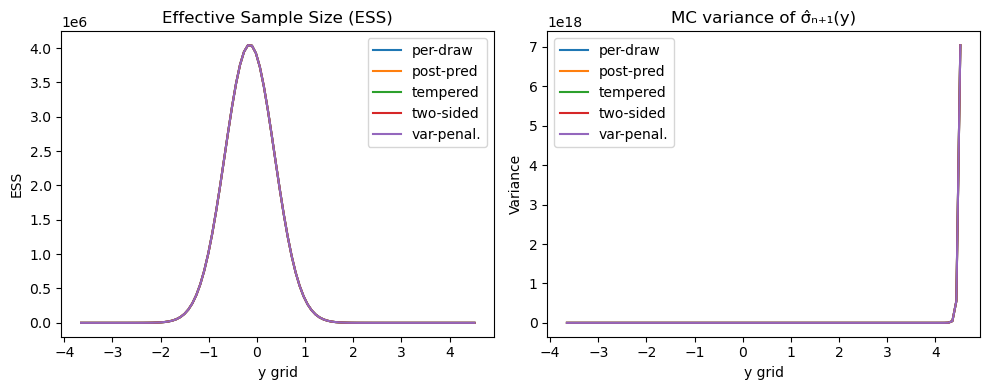

In [9]:
# ------------------------------------------------------------
# 0.  Imports and helpers already defined in earlier cells
# ------------------------------------------------------------
import jax.numpy as jnp
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial
from src.nonconformity_score import *

# builder functions and AOI helpers must be in the namespace:
#   build_logp_samp_n
#   build_logp_samp_n_postpred
#   build_logp_samp_n_tempered
#   build_logp_samp_n_two_sided
#   build_logp_samp_n_var_penalised
#   build_logwjk,  compute_rank_IS,  diagnose_IS_weights
#   run_mcmc_sparse_model

# ------------------------------------------------------------
# 1.  Load & standardise the diabetes data
# ------------------------------------------------------------
diabetes = datasets.load_diabetes()
X        = diabetes.data
y        = diabetes.target

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# split once for this demo
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42)

# ------------------------------------------------------------
# 2.  MCMC posterior draws on the training split
# ------------------------------------------------------------
samples = run_mcmc_sparse_model(
    X_train, y_train,
    c=1.0,
    num_warmup=1000,
    num_samples=8000)

theta_samp     = samples["theta"]      # (B, d)
intercept_samp = samples["theta_0"]    # (B,)
tau_samp       = samples["tau"]        # (B,)

# ------------------------------------------------------------
# 3.  Choose one new point and build a y-grid
# ------------------------------------------------------------
X_new  = X_test[0]           # (d,)     –– first test observation
y_min, y_max = float(y_train.min()), float(y_train.max())
y_grid = jnp.linspace(y_min - 2.0, y_max + 2.0, 100)   # (G,)

# ------------------------------------------------------------
# 4.  Map score names to builder functions
# ------------------------------------------------------------
score_builders = {
    "per-draw"   : build_logp_samp_n,
    "post-pred"  : build_logp_samp_n_postpred,
    "tempered"   : partial(build_logp_samp_n_tempered, lam=0.7),
    "two-sided"  : build_logp_samp_n_two_sided,
    "var-penal." : partial(build_logp_samp_n_var_penalised, beta=0.5),
}

# ------------------------------------------------------------
# 5.  Runner: compute rank, ESS, var for one score
# ------------------------------------------------------------
def get_diagnostics_one_score(builder_fn):
    # ---- build log-likelihood matrix & AOI weights -----------------------
    logp_samp_n = builder_fn(X_train, y_train,
                             theta_samp, intercept_samp, tau_samp)
    logwjk      = build_logwjk(y_grid, X_new,
                               theta_samp, intercept_samp, tau_samp)

    # ---- ranks and IS diagnostics ---------------------------------------
    rank_cp          = compute_rank_IS(logp_samp_n, logwjk)
    ESS_raw, var_raw = diagnose_IS_weights(logp_samp_n, logwjk)   # raw shapes (G, B, 1)

    # ---- collapse extra dimensions so shapes match y_grid ---------------
    ESS = jnp.squeeze(ESS_raw)        # (G, B)  →  (G, B) still
    var = jnp.squeeze(var_raw)        # (G, B)

    # each column is identical → take the first or the mean
    ESS = ESS[:, 0]                   # (G,)
    var = var[:, 0]                   # (G,)

    return rank_cp, ESS, var


# ------------------------------------------------------------
# 6.  Collect diagnostics for all score types
# ------------------------------------------------------------
diag = {name: get_diagnostics_one_score(fn)
        for name, fn in score_builders.items()}

# ------------------------------------------------------------
# 7.  Plot ESS and variance curves
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))

# ESS panel
plt.subplot(1, 2, 1)
for name, (_, ess, _) in diag.items():
    plt.plot(y_grid, ess, label=name)
plt.title("Effective Sample Size (ESS)")
plt.xlabel("y grid")
plt.ylabel("ESS")
plt.legend()

# Variance panel
plt.subplot(1, 2, 2)
for name, (_, _, var) in diag.items():
    plt.plot(y_grid, var, label=name)
plt.title("MC variance of σ̂ₙ₊₁(y)")
plt.xlabel("y grid")
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()
